In [74]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import cv2
from scipy.io import loadmat
import keras.utils
from collections import defaultdict


# from utils import convert_coords

# 

In [76]:
# manually unzip mafa data file. 
#now i create directory path to each of ['test_images', 'train_labels', 'train_images', 'test_labels']
mafa_paths = {i: os.path.join('data', i) for i in os.listdir('data')}

# get train_labels data
labels = loadmat(os.path.join(mafa_paths['train_labels'], 'LabelTrainAll.mat'))


# get path to train, test data
train_images_path = mafa_paths['train_images']
train_labels_path = os.path.join(mafa_paths['train_labels'], 'LabelTrainAll.mat')
test_images_path = mafa_paths['test_images']
test_labels_path = os.path.join(mafa_paths['test_labels'], 'LabelTrainAll.mat')
train_key = 'label_train'
test_key = 'label_test'

# Visualization

In [91]:
### i get a toy image and its bb to test my code
path = mafa_paths['train_images'] + '/' + 'train_00000001.jpg'
bb = np.array([ 90. , 160.1,  95.6,  96.9])

In [110]:
def draw_box(bbs, image):
    """bbs is a list of boxes, each has form of topleft"""
#     image = cv2.imread(image_path)
    fig,ax = plt.subplots(1)
    
    # Display the image
    ax.imshow(image)
    
    for i, bb in enumerate(bbs):
        # changed color and width to make it visible
        rect = patches.Rectangle((bb[0], bb[1]),bb[2],bb[3],linewidth=2, edgecolor='r',facecolor='none')
        
    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()

def draw_resized_box(bbs, image_path, target_size = 224):
    # load an image from path
    image = cv2.imread(image_path)
    image_shape = image.shape[:2]
    
    # resize and convert bounding box to top_left form for drawing purpose
    bbs = [resize_bb(bb, image_shape, target_size) for bb in bbs]
    bbs = [convert_coords(bb, 'centroids_to_topleft') for bb in bbs]
    
    #resize image
    image = cv2.resize(image, (target_size, target_size))
    
    #draw
    draw_box(bbs, image )

In [103]:
def resize_bb(bb, image_shape, target_size = 224):
    """ resize bbs to corresponding resized_image 
        bbs is a list of bb which has topleft form
        return bb in new size, of centroids form"""
    h, w = image_shape
    w_scale = target_size/w
    h_scale = target_size/h
    
    #convert bb to corners form
    bb = convert_coords(bb, kind = 'topleft_to_corners') 
    
    #rescale bbs
    bb[0] *= w_scale
    bb[1] *= h_scale
    bb[2] *= w_scale
    bb[3] *= h_scale
    # convert in to centroids forms
    return convert_coords(bb, kind = 'corners_to_centroids') 

# def resize_normal_bb(bbs, image_shape, target_size = 224):
#     """remember this is used as labels in models so form of bb is centroids"""
#     bbs = resize_bb(bbs, image, target_size = target_size)
    
#     # convert types of bbs from pixel to relative values to resized image
#     return [bb/target_size for bb in bbs]

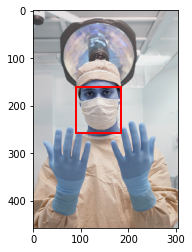

In [113]:
#test draw box
image = cv2.imread(path)
draw_box([bb], image )

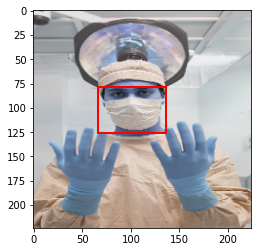

In [111]:
## test resize image and bb
draw_resized_box(bbs= [bb], image_path= path, target_size= 224)

In [ ]:
### i learn to create data_generator from this link:
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence

# Getting labels

In [77]:
#dictionary of form {'train': [image_ids], 'val':['image_ids'], 'test':image_ids}
partition = {} 

#dict : {'image_id': np.array shape(m, 4) coords of all bbs in images}
labels = {}

In [78]:
train_ids = []
val_ids = []
test_ids = []
target_size = 224
m = 4 #######

In [79]:
def get_raw_labels(path, key):
    """ return dict labs = {ids: [bbs]} fromlabel path
    key is 'label_train' for training or 'label_test' for testing data'"""
    
    #load label
    labels = loadmat(os.path.join(mafa_paths['train_labels'], 'LabelTrainAll.mat'))
    
    labels = labels[key][0]
    
    # grabs all bounding boxes in to a dict. 
    # Im intend to implement an face detection so no classes label included
    labs = defaultdict()
    for lab in labels:
        bbs = [bb[:4] for bb in lab[-1]]
        labs[lab[-2][0]] = bbs

    return labs

In [125]:
raw_train_labels = get_raw_labels(train_labels_path, key = 'label_train')

23


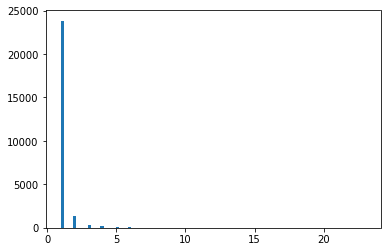

In [130]:
# how many bb in each images?
len_bbs = []
for bbs in raw_train_labels.values():
    len_bbs.append(len(bbs))

plt.hist(len_bbs, bins = 100)
plt.plot()


print(max(len_bbs))

In [80]:
def spatial_shape(path):
    return cv2.imread(path).shape[:2]

In [132]:
def get_labels(imgs_path, labels_path,key ,  target_size = 224):
    """create dict of labels {id: pad invalid bbs, resize bb}
       key is 'label_train' for training or 'label_test' for testing data'
       """
    # create a dict labs = {ids: [bbs]} each bb: top_left, wh [x1, y1, w, h] dtype = int16
    _labs = get_raw_labels(labels_path, key)
    
    #list of paths for images
    img_paths = os.listdir(imgs_path)
    
    #create an array to contain labels for each image
    labs = np.zeros(shape = (len(img_paths), m, 4))
    
    for i, ID in enumerate(img_paths):
        
        #get spatial shape of an image
        shape = spatial_shape(imgs_path + '/' + ID)
        
        # loop though each box of an image, 
        # resize, normalize, can convert each bb into centroids form
        for j,lab in enumerate(_labs[ID]):
            
            # i only choose max bb = 4 and delete all other bbs left
            if j < m:
                bbox = resize_bb(bb = lab, image_shape = shape, target_size = target_size)
                bbox /= target_size
                labs[i][j] = bbox
            else: break
            
    return labs

In [133]:
train_labels = get_labels(train_images_path, train_labels_path, key = 'label_train')
# test_labels = labels(test_images_path, test_labels_path, key = 'label_test')

(25876, 4, 4)


/home/nguyenmt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in ubyte_scalars
  # Remove the CWD from sys.path while we load stuff.
/home/nguyenmt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in ubyte_scalars


In [135]:
train_labels[0]

array([[0.58705357, 0.34821429, 0.14732143, 0.23214286],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

In [141]:
print('images with 4 bbs')
train_labels[13]

images with 4 bbs


array([[0.12276786, 0.20982143, 0.16517857, 0.19642857],
       [0.57589286, 0.22098214, 0.13392857, 0.15625   ],
       [0.88392857, 0.22767857, 0.13392857, 0.16071429],
       [0.14732143, 0.84598214, 0.16964286, 0.20089286]])

# Data Generator

In [30]:
def show_image(path):
    plt.imshow(preprocess_image(path))
    plt.show()

In [32]:
def preprocess_image(path):
    "load + resize + normalize image"
    img = cv2.imread(path)
    img = cv2.resize(img, (224, 224))
    img /= 255
    return img

In [25]:


class DataGenerator(keras.utils.Sequence):
    
    def __init__(self, list_ids, labels, m, spatial_dim = (224, 224), 
                 batch_size = 128, n_channels = 3, shuffle = True):
        """create an data_generator instance
            m: maximum number of bounding boxes in an image (can be our choice?)
            labels: np.array (m, 4)
        ex: train_data = DataGenerator(list_ids = train_ids, labels= train_labels)"""

        self.list_ids = list_ids
        self.labels = labels
        self.m = m
        self.spatial_dim = spatial_dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def on_epoch_end(self):
        """shuffle indicies of ids after each epoch to shuffle data"""
        self.indices = np.arange(len(self.list_ids))
        if self.shuffle == True : np.random.shuffle(self.indices)
            
    def _data_generator(self, bacth_list_ids):
        """load and preprocess data
        batch_list_ids: list of ids for this mini_batch
        -output: minibatch of
            -train_images: nd.array (batch_size, 224, 244, 3)
            -labels: nd.array (batch_size, m , 4 )

        Because images can have various number of bb, 
        for imgs that have less than m boxes, we pad it with invalid boxes which bb = [0, 0, 0, 0]
        """
        X = np.empty((self.batch_size, *self.spatial_dim, self.n_channels))
        Y = np.empty((self.batch_size, self.m, 4))

        for i, ID in enumerate(batch_list_ids):
            X[i, ] = preprocess_image(path = 'data/' + ID )
            y[i] = labels[i]

        return X, Y
    
    def __getitems__(self, idx):
        """get 1 minibatch for data
        idx: index of the batch , ex: batch_0, batch_1
        ex: train_data = DataGenerator(list_ids = train_ids, labels= train_labels)
            train_data[0] will return (np.array) images and labels of a batch"""

        # grab indices from self.indices
        indices = self.indices[idx*self.batch_size : (idx + 1)*self.batch_size]

        # get ids of data from their coresponding indices
        batch_list_ids = [self.list_ids[ID] for ID in indices]

        #grab images and labels from batch_list_ids
        return self._data_generator(batch_list_ids )
            